# Quantization in Depth

Resource: https://www.deeplearning.ai/short-courses/quantization-in-depth/

## Linear quantization

In [2]:
import torch

### Quantization

In [145]:
def linear_q_with_scale_and_zero_point(
    tensor,
    scale,
    zero_point,
    dtype=torch.int8,
):
    scaled_and_shifted_tensor = tensor / scale + zero_point
    
    rounded_tensor = torch.round(scaled_and_shifted_tensor)
    
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max
    
    q_tensor = rounded_tensor.clamp(q_min, q_max).to(dtype)
    
    return q_tensor

In [4]:
test_tensor = torch.tensor(
    [[191.6, -13.6, 728.6],
     [92.14, 295.5, -184],
     [0, 684.6, 245.5]]
)

In [5]:
scale = 3.5
zero_point = -70

In [6]:
quantized_tensor = linear_q_with_scale_and_zero_point(
    test_tensor,
    scale, 
    zero_point,
)

In [7]:
quantized_tensor

tensor([[ -15,  -74,  127],
        [ -44,   14, -123],
        [ -70,  126,    0]], dtype=torch.int8)

### Dequantization

In [8]:
dequantized_tensor = scale * (quantized_tensor.float() - zero_point)

In [9]:
dequantized_tensor

tensor([[ 192.5000,  -14.0000,  689.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000,  686.0000,  245.0000]])

In [10]:
scale * (quantized_tensor - zero_point)

tensor([[ 192.5000,  -14.0000, -206.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000, -210.0000,  245.0000]])

In [11]:
def linear_dequantization(
    quantized_tensor,
    scale,
    zero_point
):
    return scale * (quantized_tensor.float() - zero_point)

In [12]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)

In [13]:
dequantized_tensor

tensor([[ 192.5000,  -14.0000,  689.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000,  686.0000,  245.0000]])

### Quantization error

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=None):
    """
    Plot a heatmap of tensors using seaborn
    """
    sns.heatmap(tensor.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


def plot_quantization_errors(original_tensor, quantized_tensor, dequantized_tensor, dtype = torch.int8, n_bits = 8):
    """
    A method that plots 4 matrices, the original tensor, the quantized tensor
    the de-quantized tensor and the error tensor.
    """
    # Get a figure of 4 plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the first matrix
    plot_matrix(original_tensor, axes[0], 'Original Tensor', cmap=ListedColormap(['white']))

    # Get the quantization range and plot the quantized tensor
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    plot_matrix(quantized_tensor, axes[1], f'{n_bits}-bit Linear Quantized Tensor', vmin=q_min, vmax=q_max, cmap='coolwarm')

    # Plot the de-quantized tensors
    plot_matrix(dequantized_tensor, axes[2], 'Dequantized Tensor', cmap='coolwarm')

    # Get the quantization errors
    q_error_tensor = abs(original_tensor - dequantized_tensor)
    plot_matrix(q_error_tensor, axes[3], 'Quantization Error Tensor', cmap=ListedColormap(['white']))

    fig.tight_layout()
    plt.show()

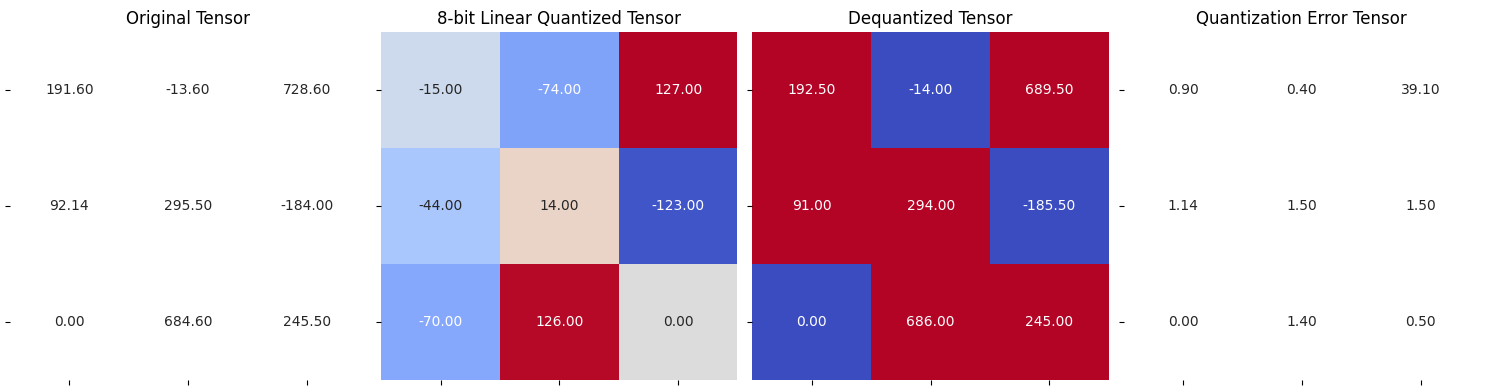

In [15]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [16]:
dequantized_tensor - test_tensor

tensor([[  0.9000,  -0.4000, -39.1000],
        [ -1.1400,  -1.5000,  -1.5000],
        [  0.0000,   1.4000,  -0.5000]])

In [17]:
(dequantized_tensor - test_tensor).square()

tensor([[8.0999e-01, 1.6000e-01, 1.5288e+03],
        [1.2996e+00, 2.2500e+00, 2.2500e+00],
        [0.0000e+00, 1.9601e+00, 2.5000e-01]])

In [18]:
(dequantized_tensor - test_tensor).square().mean()

tensor(170.8653)

## Asymetric linear quantization

### Finding scale and zero point

In [19]:
test_tensor

tensor([[ 191.6000,  -13.6000,  728.6000],
        [  92.1400,  295.5000, -184.0000],
        [   0.0000,  684.6000,  245.5000]])

In [20]:
q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max

In [21]:
q_min, q_max

(-128, 127)

In [22]:
r_min = test_tensor.min().item()
r_max = test_tensor.max().item()

In [23]:
r_min, r_max

(-184.0, 728.5999755859375)

In [24]:
scale = (r_max-r_min)/(q_max-q_min)

In [25]:
scale

3.578823433670343

In [26]:
zero_point = q_min - (r_min/scale)

In [27]:
zero_point

-76.58645490333825

In [28]:
zero_point = int(round(zero_point))

In [29]:
zero_point

-77

In [30]:
def get_q_scale_and_zer_point(tensor, dtype=torch.int8):
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    
    r_min, r_max = tensor.min().item(), tensor.max().item()
    
    scale = (r_max-r_min) / (q_max-q_min)
    
    zero_point = q_min - (r_min/scale)
    
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        zero_point = int(round(zero_point))
    
    return scale, zero_point

In [31]:
new_scale, new_zero_point = get_q_scale_and_zer_point(test_tensor)

In [32]:
new_scale, new_zero_point

(3.578823433670343, -77)

In [33]:
quantized_tensor = linear_q_with_scale_and_zero_point(
    test_tensor,
    new_scale,
    new_zero_point
)

In [34]:
quantized_tensor

tensor([[ -23,  -81,  127],
        [ -51,    6, -128],
        [ -77,  114,   -8]], dtype=torch.int8)

In [35]:
dequantized_tensor = linear_dequantization(
    quantized_tensor,
    new_scale,
    new_zero_point
)

In [36]:
dequantized_tensor

tensor([[ 193.2565,  -14.3153,  730.0800],
        [  93.0494,  297.0423, -182.5200],
        [   0.0000,  683.5552,  246.9388]])

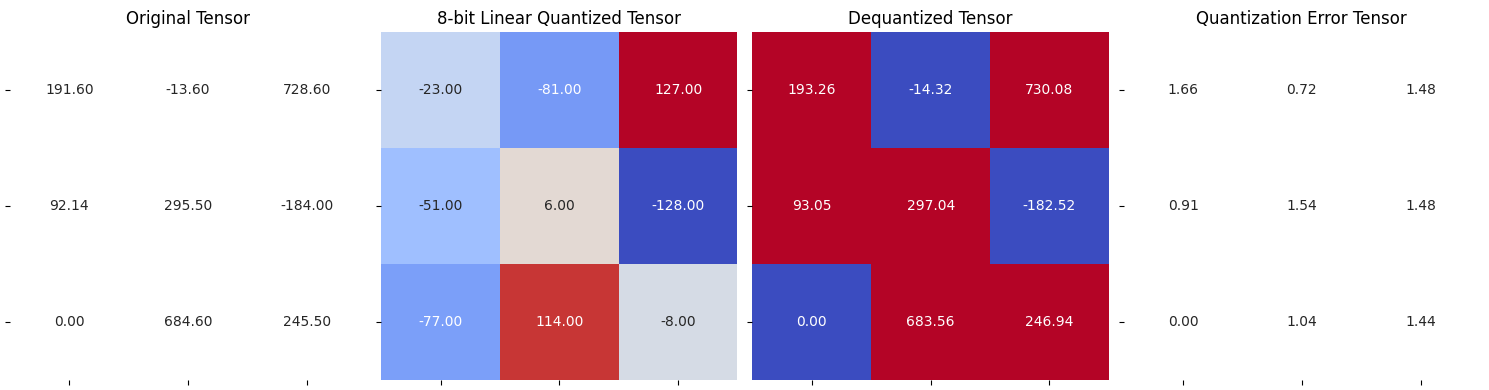

In [37]:
plot_quantization_errors(
    test_tensor,
    quantized_tensor,
    dequantized_tensor,
)

In [38]:
(dequantized_tensor-test_tensor).square().mean()

tensor(1.5560)

### Quantization and dequantization

In [39]:
def linear_quantization(
    tensor, dtype=torch.int8
):
    scale, zero_point = get_q_scale_and_zer_point(tensor, dtype)
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype)
    return quantized_tensor, scale, zero_point

In [40]:
r_tensor = torch.randn((4,4 ))

In [41]:
r_tensor

tensor([[ 0.0943, -2.1891, -0.1823, -0.4351],
        [-1.4737, -1.5779,  1.1790,  0.8940],
        [-0.0119, -0.6167,  0.2496,  0.3351],
        [-0.2578,  0.6250, -0.6526, -0.8588]])

In [42]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)

In [43]:
quantized_tensor, scale, zero_point

(tensor([[  45, -128,   24,    5],
         [ -74,  -81,  127,  106],
         [  37,   -9,   57,   63],
         [  18,   85,  -11,  -27]], dtype=torch.int8),
 0.013208275215298522,
 38)

In [44]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)

In [45]:
dequantized_tensor

tensor([[ 0.0925, -2.1926, -0.1849, -0.4359],
        [-1.4793, -1.5718,  1.1755,  0.8982],
        [-0.0132, -0.6208,  0.2510,  0.3302],
        [-0.2642,  0.6208, -0.6472, -0.8585]])

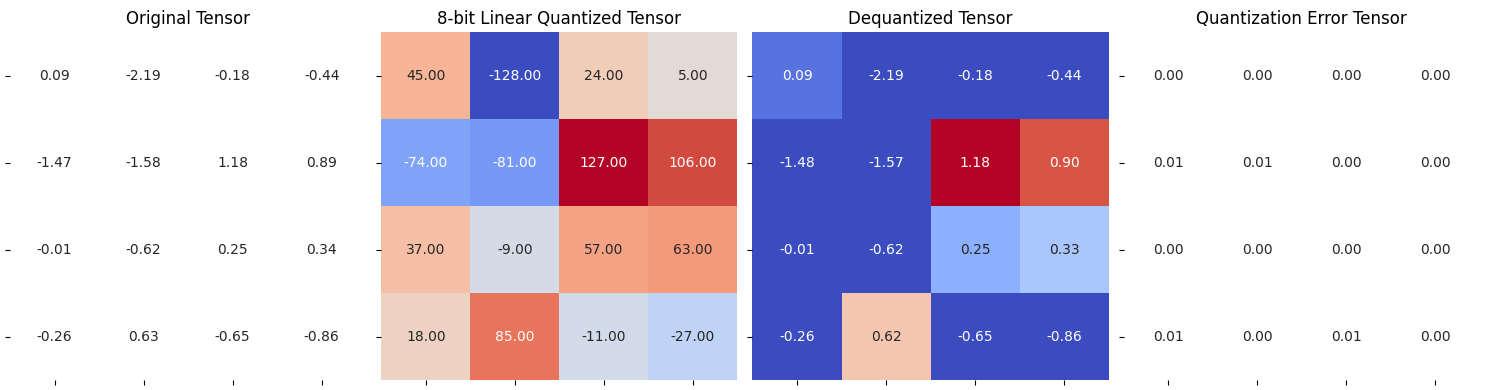

In [46]:
plot_quantization_errors(
    r_tensor,
    quantized_tensor,
    dequantized_tensor,
)

In [47]:
(dequantized_tensor-r_tensor).square().mean()

tensor(1.5868e-05)

## Symmetric linear quantization

In [48]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max
    
    return r_max / q_max

In [49]:
test_tensor = torch.rand((4, 4))

In [50]:
test_tensor

tensor([[0.9893, 0.8417, 0.6071, 0.6783],
        [0.8942, 0.8237, 0.9465, 0.6026],
        [0.7555, 0.1978, 0.1289, 0.8582],
        [0.5225, 0.9762, 0.0228, 0.6222]])

In [51]:
get_q_scale_symmetric(test_tensor)

0.007790041251445379

In [ ]:
def linear_q_symmetric(tensor, dtype=torch.int8):
    scale = get_q_scale_symmetric(tensor)
    
    quantized_tensor = linear_q_with_scale_and_zero_point(
        test_tensor,
        scale=scale,
        zero_point=0,
        dtype=dtype
    )
    
    return quantized_tensor, scale

In [53]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

In [54]:
quantized_tensor, scale

(tensor([[127, 108,  78,  87],
         [115, 106, 122,  77],
         [ 97,  25,  17, 110],
         [ 67, 125,   3,  80]], dtype=torch.int8),
 0.007790041251445379)

In [55]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)

In [56]:
dequantized_tensor

tensor([[0.9893, 0.8413, 0.6076, 0.6777],
        [0.8959, 0.8257, 0.9504, 0.5998],
        [0.7556, 0.1948, 0.1324, 0.8569],
        [0.5219, 0.9738, 0.0234, 0.6232]])

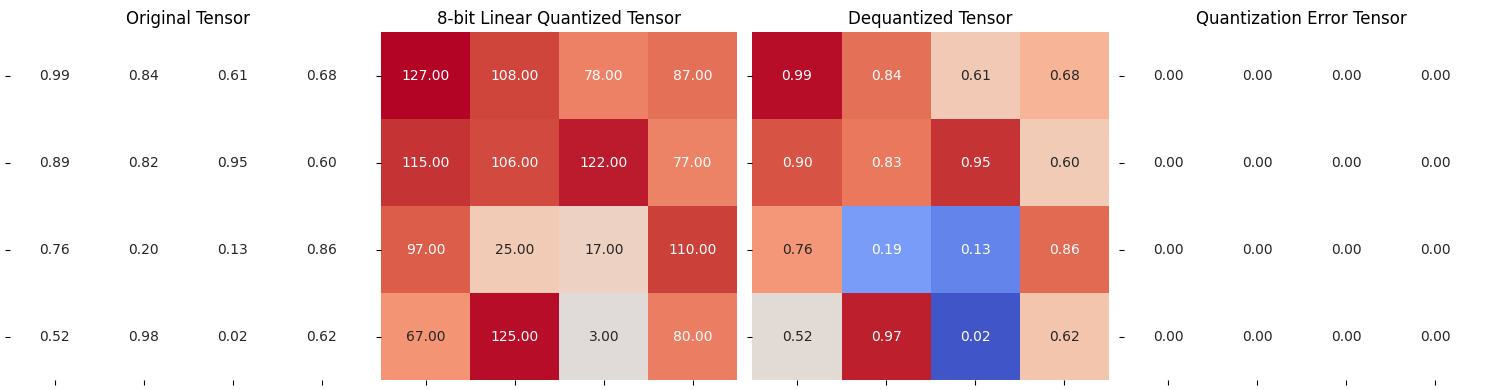

In [57]:
plot_quantization_errors(
    test_tensor,
    quantized_tensor,
    dequantized_tensor
)

In [58]:
(dequantized_tensor - test_tensor).mean().square()

tensor(2.3274e-08)

## Finer granularity

In [59]:
test_tensor = torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5, -184],
     [0, 684.6, 245.5]]
)

In [61]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

In [62]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)

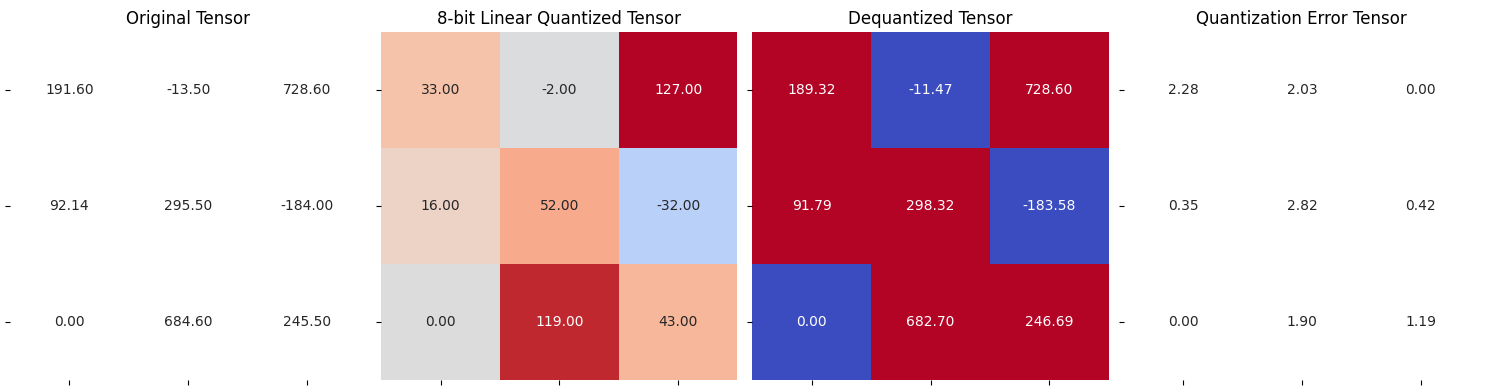

In [63]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [66]:
(dequantized_tensor - test_tensor).mean().square()

tensor(0.0462)

## Per-channel quanization

In [ ]:
def linear_q_symmetric_per_channel(tensor, dim, dtype=torch.int8):
    
    

    return quantized_tensor, scale

In [67]:
test_tensor = torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5, -184],
     [0, 684.6, 245.5]]
)

In [74]:
dim=0
output_dim = test_tensor.shape[dim]

In [75]:
output_dim

3

In [70]:
dim=1
output_dim = test_tensor.shape[dim]

In [71]:
output_dim

3

In [72]:
scale = torch.zeros(output_dim)

In [73]:
scale

tensor([0., 0., 0.])

In [77]:
for index in range(output_dim):
    sub_tensor = test_tensor.select(dim, index)
    # print(sub_tensor)
    scale[index] = get_q_scale_symmetric(sub_tensor)

In [78]:
scale

tensor([5.7370, 2.3268, 5.3906])

In [79]:
scale_shape = [1] * test_tensor.dim()

In [80]:
scale_shape

[1, 1]

In [81]:
scale_shape[dim] = -1

In [82]:
scale = scale.view(scale_shape)

In [83]:
scale

tensor([[5.7370],
        [2.3268],
        [5.3906]])

In [84]:
m = torch.tensor([[1,2,3], [4,5,6], [7,8,9]])

In [85]:
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [86]:
s = torch.tensor([1,5,10])

In [87]:
s

tensor([ 1,  5, 10])

In [88]:
s.shape

torch.Size([3])

In [90]:
s.view(1, 3).shape

torch.Size([1, 3])

In [91]:
s.view(1, -1).shape

torch.Size([1, 3])

In [92]:
s.view(-1, 1).shape

torch.Size([3, 1])

In [ ]:
scale = torch.tensor([[1], [5], [10]])

In [94]:
m / s

tensor([[1.0000, 0.4000, 0.3000],
        [4.0000, 1.0000, 0.6000],
        [7.0000, 1.6000, 0.9000]])

In [96]:
m / scale

tensor([[1.0000, 2.0000, 3.0000],
        [0.8000, 1.0000, 1.2000],
        [0.7000, 0.8000, 0.9000]])

In [97]:
scale.shape

torch.Size([3, 1])

In [98]:
scale = torch.tensor([[5.7370], [2.3268], [5.3906]])

In [99]:
scale.shape

torch.Size([3, 1])

In [100]:
quantized_tensor = linear_q_with_scale_and_zero_point(
    test_tensor, scale, 0
)

In [101]:
quantized_tensor

tensor([[ 33,  -2, 127],
        [ 40, 127, -79],
        [  0, 127,  46]], dtype=torch.int8)

In [112]:
def linear_q_symmetric_per_channel(r_tensor, dim, dtype=torch.int8):
    
    output_dim = r_tensor.shape[dim]
    
    scale = torch.zeros(output_dim)
    
    for index in range(output_dim):
        sub_tensor = r_tensor.select(dim, index)
        scale[index] = get_q_scale_symmetric(sub_tensor, dtype=dtype)
        
    scale_shape = [1] * r_tensor.dim()
    scale_shape[dim] = -1
    scale = scale.view(scale_shape)
    
    quantized_tensor = linear_q_with_scale_and_zero_point(
        r_tensor, scale, 0, dtype,
    )

    return quantized_tensor, scale

In [113]:
test_tensor

tensor([[ 191.6000,  -13.5000,  728.6000],
        [  92.1400,  295.5000, -184.0000],
        [   0.0000,  684.6000,  245.5000]])

In [114]:
quantized_tensor0, scale0 = linear_q_symmetric_per_channel(
    test_tensor, dim=0
)

In [115]:
quantized_tensor1, scale1 = linear_q_symmetric_per_channel(
    test_tensor, dim=1
)

In [116]:
dequantized_tensor0 = linear_dequantization(
    quantized_tensor0, scale0, 0
)

In [117]:
dequantized_tensor1 = linear_dequantization(
    quantized_tensor1, scale1, 0
)

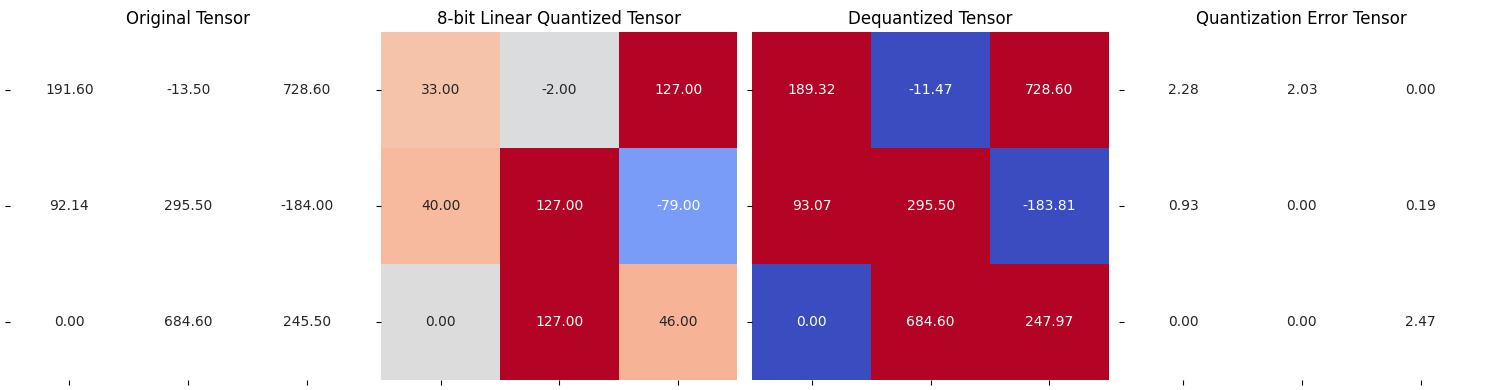

In [119]:
plot_quantization_errors(
    test_tensor,
    quantized_tensor0,
    dequantized_tensor0
)

In [121]:
(test_tensor - dequantized_tensor0).square().mean()

tensor(1.8084)

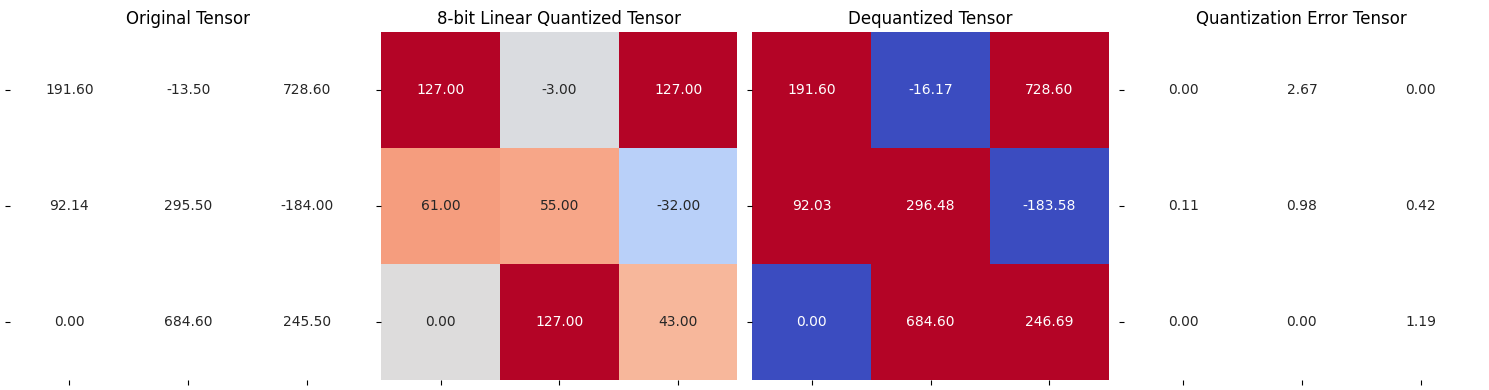

In [120]:
plot_quantization_errors(
    test_tensor,
    quantized_tensor1,
    dequantized_tensor1
)

In [122]:
(test_tensor - dequantized_tensor1).square().mean()

tensor(1.0781)

## Per group quantization

In [123]:
def linear_q_symmetric_per_group(tensor, group_size, dtype=torch.int8):
    
    t_shape = tensor.shape
    
    assert t_shape[1] % group_size == 0
    assert tensor.dim() == 2
    
    tensor = tensor.view(-1, group_size)
    
    quantized_tensor, scale = linear_q_symmetric_per_channel(
        tensor, dim=0, dtype=dtype,
    )
    
    quantized_tensor = quantized_tensor.view(t_shape)
    
    return quantized_tensor, scale

In [130]:
def linear_dequantization_per_group(quantized_tensor, scale, group_size):
    q_shape = quantized_tensor.shape
    quantized_tensor = quantized_tensor.view(-1, group_size)
    
    dequantized_tensor = linear_dequantization(
        quantized_tensor, scale, 0
    )
    
    dequantized_tensor = dequantized_tensor.view(q_shape)
    
    return dequantized_tensor

In [131]:
test_tensor = torch.rand((6, 6))

In [132]:
group_size = 3

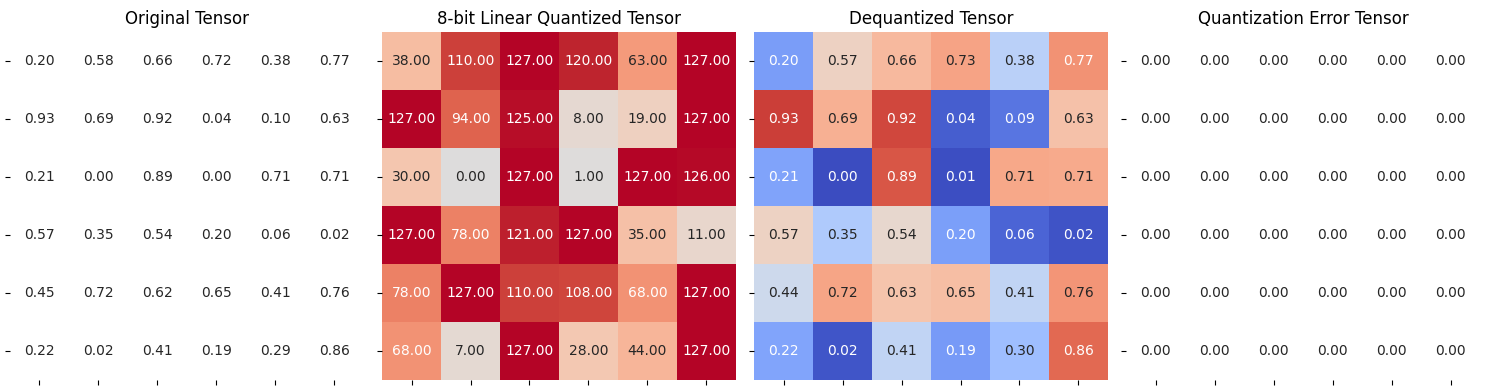

In [133]:
quantized_tensor, scale = linear_q_symmetric_per_group(
    test_tensor, group_size=group_size,
)

dequantized_tensor = linear_dequantization_per_group(
    quantized_tensor, scale, group_size=group_size,
)

plot_quantization_errors(
    test_tensor,
    quantized_tensor,
    dequantized_tensor
)

In [134]:
(test_tensor - dequantized_tensor).square().mean()

tensor(1.9516e-06)

## Weights and activations quantization

In [151]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max
    return r_max/q_max


def linear_q_symmetric(tensor, dtype=torch.int8):
    scale = get_q_scale_symmetric(tensor)
    
    quantized_tensor = linear_q_with_scale_and_zero_point(
        tensor,
        scale=scale,
        zero_point=0,
        dtype=dtype
    )

    return quantized_tensor, scale

def linear_q_with_scale_and_zero_point(r_tensor, scale, zero_point, dtype=torch.int8):

    # scale tensor and add the zero point
    scaled_and_shifted_tensor = r_tensor / scale + zero_point

    # round the tensor 
    rounded_tensor = torch.round(scaled_and_shifted_tensor)

    # we need to clamp to the min/max value of the specified dtype
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    q_tensor = rounded_tensor.clamp(q_min, q_max).to(dtype)
    return q_tensor

In [152]:
def quantized_linear_W8A32_without_bias(input, q_w, s_w, z_w):
    assert input.dtype == torch.float32
    assert q_w.dtype == torch.int8
    
    dequantized_weight = q_w.to(torch.float32) * s_w + z_w
    output = torch.nn.functional.linear(input, dequantized_weight)
    return output

In [153]:
input = torch.tensor([1, 2, 3], dtype=torch.float32)

In [154]:
weight = torch.tensor([
    [-2, -1.13, -0.42],
    [-1.51, 0.25, 1.62],
    [0.23, 1.35, 2.15],
])

In [155]:
weight

tensor([[-2.0000, -1.1300, -0.4200],
        [-1.5100,  0.2500,  1.6200],
        [ 0.2300,  1.3500,  2.1500]])

In [156]:
q_w, s_w = linear_q_symmetric(weight)

In [157]:
q_w, s_w

(tensor([[-118,  -67,  -25],
         [ -89,   15,   96],
         [  14,   80,  127]], dtype=torch.int8),
 0.016929134609192376)

In [158]:
output = quantized_linear_W8A32_without_bias(input, q_w, s_w, 0)

In [159]:
output

tensor([-5.5358,  3.8768,  9.3957])

In [160]:
fp32_output = torch.nn.functional.linear(input, weight)

In [161]:
fp32_output

tensor([-5.5200,  3.8500,  9.3800])